Yet another try, using all I've learned so far

In [2]:
import pandas as pd

In [3]:
titanic = pd.read_csv('./train.csv')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
print(titanic.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1).corr()['Survived'].sort_values(ascending=False))

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


Barely any relation with passengerid(obv), sibsp, age and parch
out of the object fields, sex will definitely have some relation
ticket will be unrelated just like passengerid
cabin has too little entries to be of any use so better to drop it
embark well have to see

In [5]:
print(titanic['Embarked'].unique())

['S' 'C' 'Q' nan]


only 3 categories so we'll try encoding it and we'll fill the null age values with the median

<Axes: xlabel='Age', ylabel='Fare'>

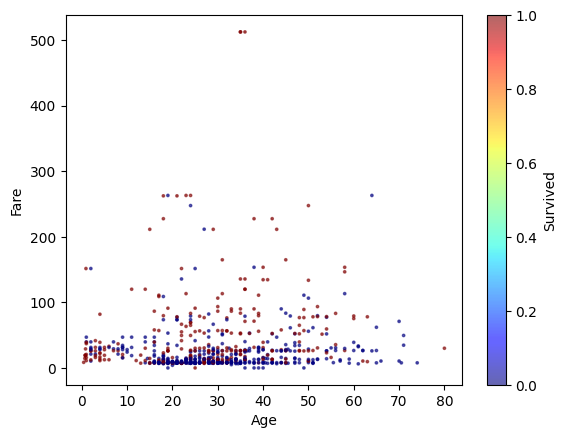

In [6]:
titanic.drop(titanic[titanic['Embarked'].isna()].index, inplace=True)

titanic_num = titanic[['PassengerId', 'Fare', 'Parch', 'SibSp', 'Age', 'Pclass']]
titanic_class = titanic[['Sex', 'Embarked']]
titanic_label = titanic[['Survived']]

titanic.plot(kind='scatter', x='Age', y='Fare', c='Survived', colormap='jet', alpha=0.6, s=3)

In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

sim_imp = SimpleImputer(strategy='median')
imputed = pd.DataFrame(sim_imp.fit_transform(titanic_num), columns=titanic_num.columns)

ord_enc = OrdinalEncoder()
encoded = pd.DataFrame(ord_enc.fit_transform(titanic_class), columns=titanic_class.columns)
titanic_final = pd.concat([imputed, encoded, titanic_label], axis=1)

titanic_final.info()
titanic_final.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    float64
 1   Fare         889 non-null    float64
 2   Parch        889 non-null    float64
 3   SibSp        889 non-null    float64
 4   Age          889 non-null    float64
 5   Pclass       889 non-null    float64
 6   Sex          889 non-null    float64
 7   Embarked     889 non-null    float64
 8   Survived     889 non-null    float64
dtypes: float64(9)
memory usage: 62.8 KB


,PassengerId,Fare,Parch,SibSp,Age,Pclass,Sex,Embarked,Survived
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,32.096681,0.382452,0.524184,29.315152,2.311586,0.649044,1.535433,0.382452
std,256.998173,49.697504,0.806761,1.103705,12.984932,0.834700,0.477538,0.792088,0.486260
min,1.000000,0.000000,0.000000,0.000000,0.420000,1.000000,0.000000,0.000000,0.000000
25%,224.000000,7.895800,0.000000,0.000000,22.000000,2.000000,0.000000,1.000000,0.000000
50%,446.000000,14.454200,0.000000,0.000000,28.000000,3.000000,1.000000,2.000000,0.000000
75%,668.000000,31.000000,0.000000,1.000000,35.000000,3.000000,1.000000,2.000000,1.000000
max,891.000000,512.329200,6.000000,8.000000,80.000000,3.000000,1.000000,2.000000,1.000000


In [8]:
titanic_final.corr()['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.009026
Age            0.001543
PassengerId   -0.006023
Parch         -0.010241
Pclass        -0.022947
Sex           -0.023116
Embarked      -0.023888
SibSp         -0.078454
Name: Survived, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Fare         889 non-null    float64
 1   Parch        889 non-null    float64
 2   SibSp        889 non-null    float64
 3   Age          889 non-null    float64
 4   Pclass       889 non-null    float64
 5   Sex          889 non-null    float64
 6   Embarked     889 non-null    float64
 7   PassengerId  889 non-null    float64
 8   Survived     889 non-null    float64
dtypes: float64(9)
memory usage: 69.5 KB


<Axes: >

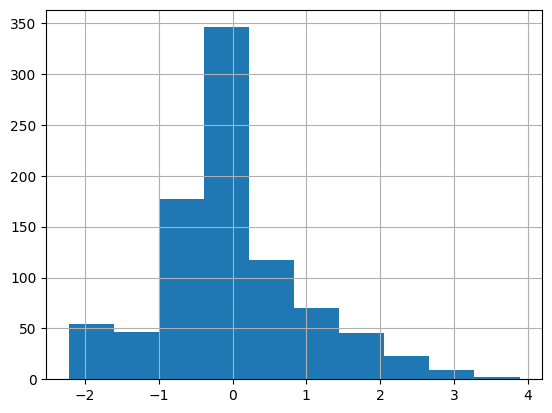

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_pipe = Pipeline([
    ('imputing', SimpleImputer(strategy='median')),
    ('scaling', StandardScaler()),
])

overall_pipe = ColumnTransformer([
    ('num', num_pipe, ['Fare', 'Parch', 'SibSp', 'Age', 'Pclass']),
    ('class', OrdinalEncoder(), titanic_class.columns),
    ('passthru', 'passthrough', ['PassengerId', 'Survived'])
])

train = pd.read_csv('./train.csv').drop('Cabin', axis=1)

titanic_final = pd.DataFrame(overall_pipe.fit_transform(train), columns=['Fare', 'Parch', 'SibSp', 'Age', 'Pclass', 'Sex', 'Embarked', 'PassengerId', 'Survived'])
titanic_final.dropna(inplace=True)
titanic_final.info()

titanic_final['Age'].hist()

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

titanic_final['age_brackets'] = pd.cut(titanic_final['Age'], bins=[-3, -1.5, 0, 1.5, 3, np.inf], labels=[1, 2, 3, 4, 5])
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(titanic_final, titanic_final['age_brackets']):
    strat_train_x = titanic_final.iloc[train_index]
    strat_train_y = titanic_final.iloc[train_index, 8]
    strat_test_x = titanic_final.iloc[test_index]
    strat_test_y = titanic_final.iloc[test_index, 8]

strat_train_x.drop(['age_brackets', 'PassengerId', 'Survived'], axis=1, inplace=True)
strat_test_x.drop(['age_brackets', 'PassengerId', 'Survived'], axis=1, inplace=True)


/tmp/ipykernel_5089/2671032709.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_train_x.drop(['age_brackets', 'PassengerId', 'Survived'], axis=1, inplace=True)
/tmp/ipykernel_5089/2671032709.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_test_x.drop(['age_brackets', 'PassengerId', 'Survived'], axis=1, inplace=True)


In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

knn = RandomForestClassifier()
score = cross_val_score(knn, strat_train_x, strat_train_y, cv=10)
print(score.mean())

print(knn.fit(strat_train_x, strat_train_y).predict(strat_test_x))

0.8087050078247261
[0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0.]


In [75]:
from sklearn.metrics import classification_report

pred = knn.fit(strat_train_x, strat_train_y).predict(strat_test_x)
print(classification_report(strat_test_y, pred))
strat_test_x.info()


              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       105
         1.0       0.79      0.78      0.79        73

    accuracy                           0.83       178
   macro avg       0.82      0.82      0.82       178
weighted avg       0.83      0.83      0.83       178

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 362 to 797
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Fare      178 non-null    float64
 1   Parch     178 non-null    float64
 2   SibSp     178 non-null    float64
 3   Age       178 non-null    float64
 4   Pclass    178 non-null    float64
 5   Sex       178 non-null    float64
 6   Embarked  178 non-null    float64
dtypes: float64(7)
memory usage: 11.1 KB


In [76]:
test = pd.read_csv('./test.csv')

test.drop(['Cabin', 'Name'], inplace=True, axis=1)
test_pid = test['PassengerId']


test['Survived'] = test['Age']
test_fin = pd.DataFrame(overall_pipe.transform(test))
test_fin.drop(test_fin.columns[7: 9], axis=1, inplace=True)

pred = knn.fit(strat_test_x, strat_test_y).predict(test_fin)

cc = pd.concat([test_pid, pd.DataFrame(pred, dtype=np.uint32)], ignore_index=True, axis=1)
cc.to_csv('./final.csv', index=False)

/home/aaditya/Documents/ML/env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
